100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21894.64it/s]


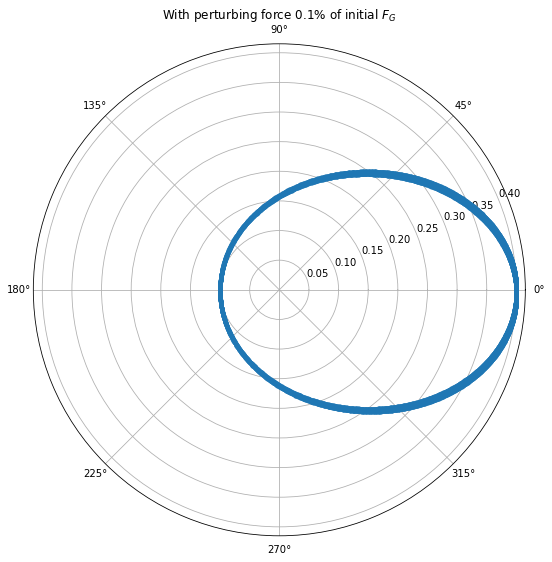

Perihelion: 0.100 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 20963.98it/s]


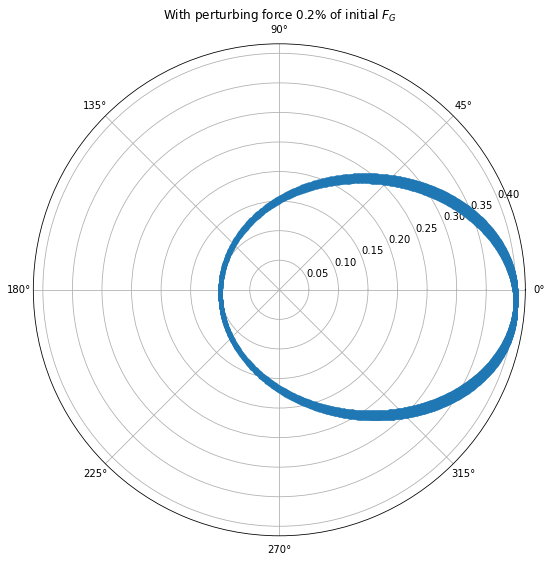

Perihelion: 0.400 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21458.99it/s]


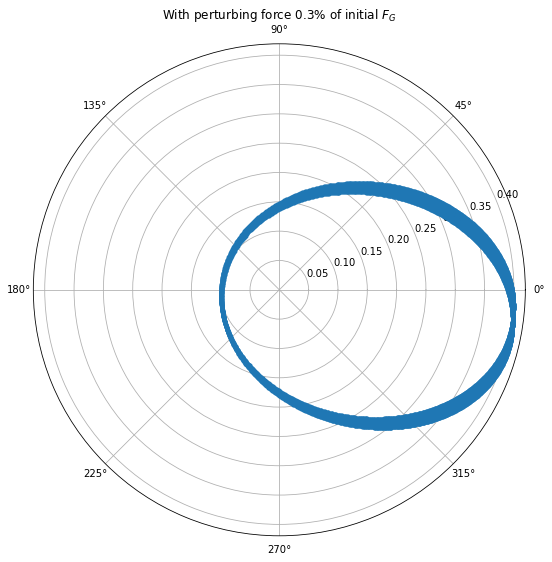

Perihelion: 0.396 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21597.71it/s]


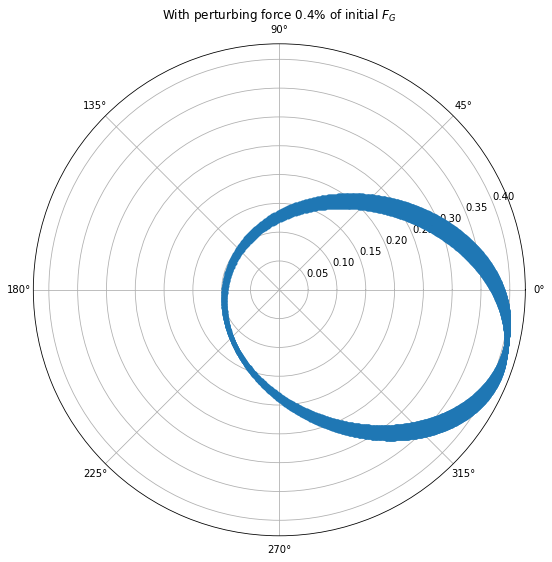

Perihelion: 0.386 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21164.22it/s]


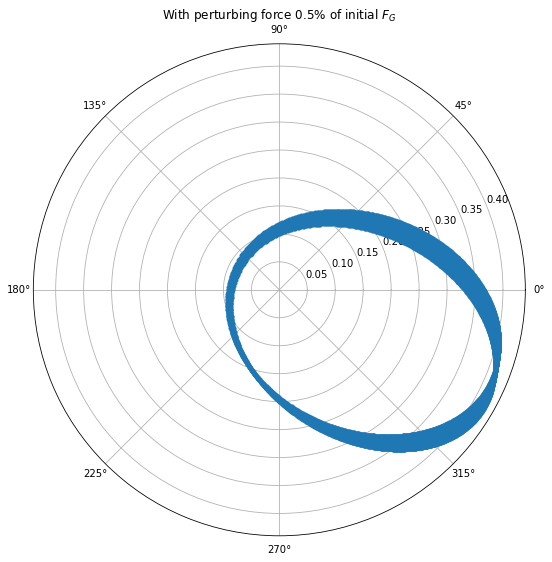

Perihelion: 0.361 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 20920.54it/s]


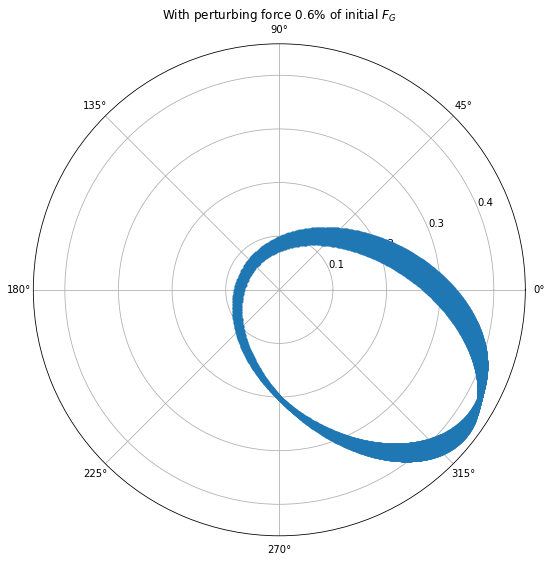

Perihelion: 0.316 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 20876.94it/s]


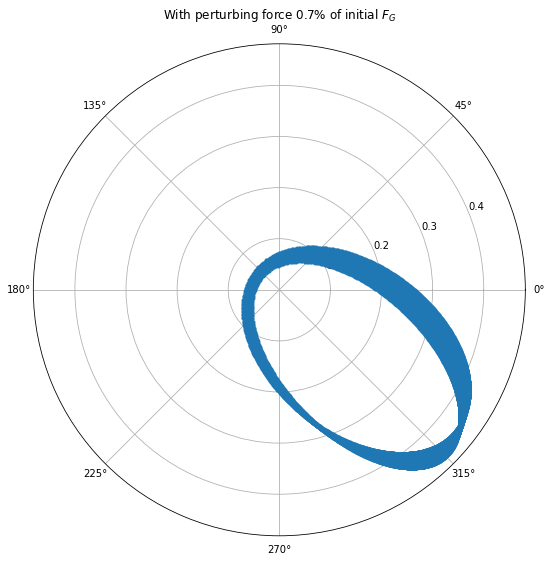

Perihelion: 0.247 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21505.45it/s]


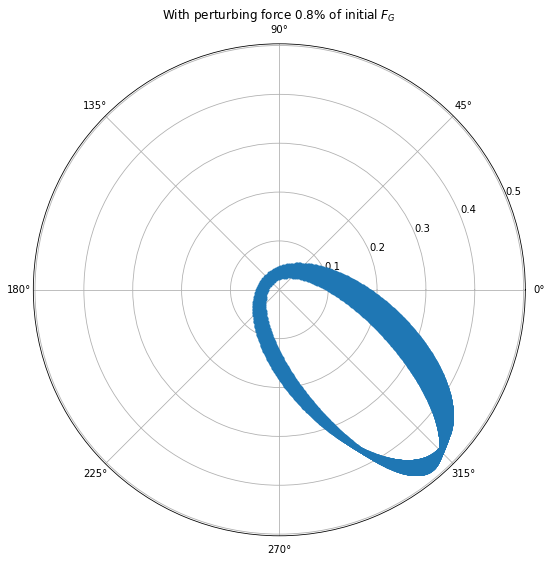

Perihelion: 0.161 AU


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 22371.41it/s]


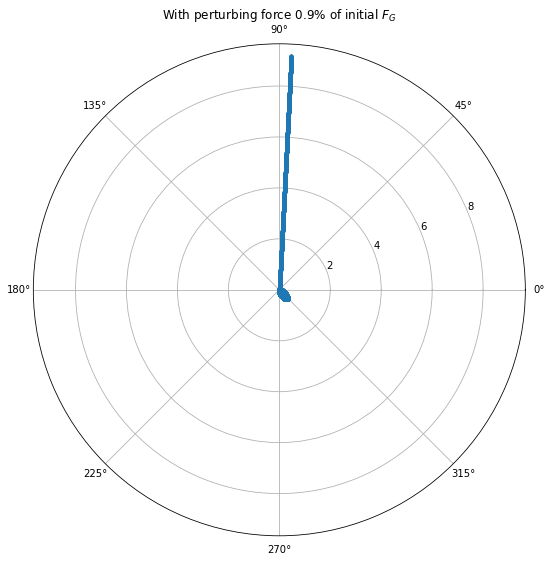

Perihelion: 0.071 AU


In [26]:
# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nm4p.rk4 import rk4
from nm4p.rka import rka

# Define gravrk function used by the Runge-Kutta routines
def gravrk(s, t, GM):
    """
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), v(0), v(1)]
    :param t: Time (not used here, included to match derivsRK input)
    :param GM: Parameter G*M - gravitational constant * solar mass Units [AU^3/yr^2]
    :return: deriv: Derivatives [dr(0/dt), dr(1)/dt, dv(0)/dt, dv(1)/dt]
    """

    # Compute acceleration
    r = s[:2]  # Unravel the vector s into position and velocity
    v = s[2:]
    accel = -GM * r / np.linalg.norm(r)**3 +  mu_mercury* r / np.linalg.norm(r)**3 # Gravitational acceleration
    accel[0] -= perturbingForce 
    # Return derivatives
    deriv = np.array([v[0], v[1], accel[0], accel[1]])

    return deriv


# Set physical parameters
GM = 4 * np.pi**2  # Gravitational constant * Mass of sun [AU^3/yr^2]
conversion = 2.97449433e-19 # [m^3/s^2] to [AU^3/yr^2] 

mass = 1.0  # Mass of comet (reference mass)
massMercury = 3.285e23 # kg
massSun = 1.99e30 # kg

mu_mercury = 2.2032e13 # m^3/s^2
mu_mercury = mu_mercury*conversion # [AU^3/yr^2]


# Set initial position and velocity of the comet.
# r0 = 1 # AU
r0 = .4 # Mercury is about .4 AU from the sun
# v0 = 6.28
v0 = 2*np.pi
# v0 = (GM/r0)**.5
r = np.array([r0, 0.0])
v = np.array([0.0, v0])

state = np.array([r[0], r[1], v[0], v[1]])  # State used by R-K routines

adaptErr = 1.0E-3  # Error parameter used by adaptive Runge-Kutta
time = 0.0

for percent in np.arange(0.001, 0.01, 0.001):
    # Perturbation
    perturbingForce = percent*GM/r0**2

    # Loop over the desired number of steps using the specified numerical method.
    nStep = 10000
    tau = .0001
    NumericalMethod = 3

    rplot = np.empty(nStep)
    thplot = np.empty(nStep)
    tplot = np.empty(nStep)
    vplot = np.empty(nStep)
    kinetic = np.empty(nStep)
    potential = np.empty(nStep)
    stoplist = [] # List to populate with indices where the orbit completes

    for iStep in tqdm(range(nStep)):

        # Record position and energy for plotting
        rplot[iStep] = np.linalg.norm(r)  # Record radial position and angle for polar plot
        thplot[iStep] = np.arctan2(r[1], r[0]) # domain is [-pi, pi]
        tplot[iStep] = time
        kinetic[iStep] = 0.5*massMercury*np.linalg.norm(v)**2  # Record kinetic and potential energy
        potential[iStep] = - GM*massMercury/np.linalg.norm(r)

        # Calculate new position and velocity using the desired method
        if NumericalMethod == 1:
            accel = -GM*r/np.linalg.norm(r)**3
            r += tau*v  # Euler Step
            v += tau*accel
            time += tau
        elif NumericalMethod == 2:
            accel = -GM * r / np.linalg.norm(r) ** 3
            v += tau * accel
            r += tau * v  # Euler-Cromer Step
            time += tau
        elif NumericalMethod == 3:
            state = rk4(state, time, tau, gravrk, GM)
            r = state[:2]  # 4th Order Runge-Kutta
            v = state[2:]
            vplot[iStep] = np.linalg.norm(v) 
            time += tau
        elif NumericalMethod == 4:
            state, time, tau = rka(state, time, tau, adaptErr, gravrk, GM)
            r = state[:2]  # 4th Order Runge-Kutta
            v = state[2:]
        else:
            raise ValueError('Invalid NumericalMethod input. Choose: 1) Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive Runge-Kutta  ')
        # print(np.isclose(thplot[iStep],  3, rtol=1e-2, atol = 1e-2))
        if np.sign(thplot[iStep - 1]) - np.sign(thplot[iStep]) == -2:
            stoplist.append(iStep)
#             print(f'{len(stoplist)} period(s)')


    # Graph the trajectory  and energy of the comet over time.
    totalE = kinetic + potential  # total energy

    text = round(100*round(percent, 3), 3)
    fig = plt.figure(figsize=(20.0, 9))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(thplot, rplot, '.',)
    # ax.plot(thplot[:stoplist[0]], rplot[:stoplist[0]], '+',)
    ax.set_title(f'With perturbing force {text}% of initial $F_G$')
    # ax.set_rmax(2)

    ax.grid(True)
    fig.tight_layout(pad=5.0)

#     ax2 = fig.add_subplot(122)
#     ax2.plot(tplot, kinetic, ls='-.', label='Kinetic')
#     ax2.plot(tplot, potential, ls='--', label='Potential')
#     ax2.plot(tplot, totalE, ls='-', label='Total')
#     ax2.set_xlabel('Time (yr)')
#     ax2.set_ylabel(r'Energy ($M~AU^3/yr^2$)')
#     ax2.legend()

    # # fig = plt.figure(figsize=(20.0, 9))
    # ax = fig.add_subplot(122, polar=True)
    # # ax.plot(thplot, rplot, '.',)
    # ax.plot(thplot[stoplist[0]:stoplist[1]], rplot[stoplist[0]:stoplist[1]], '+',)
    # ax.set_title('Distance (AU)')
    # ax.set_rmax(2)


    plt.show()

    periods = np.array(stoplist) * tau
    angular_velocities = 2*np.pi/periods
    halfpind = int(stoplist[0] / 2)
    semimajor = (rplot[stoplist[0]] + rplot[halfpind]) / 2

    ecc = r0/semimajor - 1
    perih = (1 - ecc)*semimajor

    ## Test program and compare measured eccentricity with predicted value
    eTot = np.mean(totalE)
    angMom = r0*v0

#     print(f'Period: {periods} AU-yr')
#     print(f'Angular Velocities: {angular_velocities} rads/revolution')

#     print(f'Semimajor axis: {semimajor:.3f} AU')
    print(f'Perihelion: {perih:.3f} AU')
#     print(f'Eccentricity calculated: {ecc:.3f}')



In [25]:
# """
# Code from https://arxiv.org/pdf/1803.01678.pdf - A primer to numerical simulations: The perihelion
# motion of Mercury
# """

# # Import everything from vpython (need graphics output, vectors, etc.)
# from vpython import *

# Set up display
# scene.width      = 1680
# scene.height     = 1024
# scene.background = color.white
# scene.center     = vector(0, -2, 0)
# # scene.visible = 0

# # Definition of parameters
# # Values computed using https://nssdc.gsfc.nasa.gov/planetary/factsheet
# rM0 = 4.60    # Initial radius of Mercury orbit, in units of R0
# vM0 = 5.10e-1 # Initial orbital speed of Mercury, in units of R0/T0
# c_a = 9.90e-1 # Base acceleration of Mercury, in units of R0**3/T0**2
# rS  = 2.95e-7 # Schwarzschild radius of Sun,in units of R0
# rL2 = 8.19e-7 # Specific angular momentum, in units of R0**2


# # Initialize distance and velocity vectors of Mercury (at perihelion)
# vec_rM0 = vector(0, rM0, 0)
# vec_vM0 = vector(vM0, 0, 0)

# # Define graphical objects; M = Mercury, S = Sun ...
# M = sphere(pos=vec_rM0,         radius=0.5,  color=color.red   )
# S = sphere(pos=vector(0, 0, 0), radius=1.5,  color=color.yellow)
# # ... and the initial velocities
# M.velocity = vec_vM0
# S.velocity = vector(0, 0, 0)

# # Add a visible trajectory to Mercury
# M.trajectory = curve(color=color.black, radius=0.005)

# def evolve_mercury(vec_rM_old, vec_vM_old, alpha, beta):
#     """
#     Advance Mercury in time by one step of length dt.
#     Arguments:
#          - vec_rM_old: old position vector of Mercury
#          - vec_vM_old: old velocity vector of Mercury
#          - alpha: strength of 1/r**3 term in force
#          - beta: strength of 1/r**4 term in force
#     Returns:
#          - vec_rM_new: new position vector of Mercury
#          - vec_vM_new: new velocity vector of Mercury
#     """

#     # Compute the factor coming from General Relativity
#     fact = 1 + alpha * rS / vec_rM_old.mag + beta * rL2 / vec_rM_old.mag**2
#     # Compute the absolute value of the acceleration
#     aMS = c_a * fact / vec_rM_old.mag**2
#     # Multiply by the direction to get the acceleration vector
#     vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
#     # Update velocity vector
#     vec_vM_new = vec_vM_old + vec_aMS * dt
#     # Update position vector
#     vec_rM_new = vec_rM_old + vec_vM_new * dt
#     return vec_rM_new, vec_vM_new

# # Provide function to compute angle between vectors
# def angle_between(v1, v2):
#     """Compute angle between two vectors. Result is in degrees."""
#     return acos( dot(v1, v2) / (v1.mag * v2.mag) ) * 180. / pi

# # Define run parameters and help variables
# dt = 2. * vM0 / c_a / 200 # Time step
# alpha      = 0.0          # Strength of 1/r**3 term
# beta       = 1.e5         # Strength of 1/r**4 term
# vec_r_last = vec_rM0      # Previous position of Mercury
# turns      = 0            # Number of completed turns
# max_turns  = 10           # Maximum number of turns
# list_perih = list()       # List of perihelion locations
# sum_angle  = 0.           # Angle between first and last perihelion

# # Find perihelion for each turn and print it out
# while turns < max_turns:
#     vec_r_before_last = vec_r_last
#     vec_r_last        = vector(M.pos)
#     # Set the frame rate: shows four earth days at once
#     rate(1e4)
#     # Update the drawn trajectory with the current position
#     M.trajectory.append(pos=M.pos)
#     # Update the velocity and position
#     M.pos, M.velocity = evolve_mercury(M.pos, M.velocity, alpha, beta)
#     # Check if just past perihelion
#     if vec_r_before_last.mag > vec_r_last.mag < M.pos.mag:
#         turns = turns+1
#         list_perih.append(vec_r_last)
#         if turns > 1:
#             # Draw location of perihelion
#             sphere(color=color.green, radius=0.2, pos=vec_r_last)
#             # Display intermediate results
#             print("turn: n={n}, perihelion growth: delta Theta={angle}".format(
#                 n=turns, angle=angle_between(list_perih[-2], list_perih[-1])
#             ))
#             # Note that list_perih[-2] accesses the second last and
#             #  list_perih[-1] the last element in the list
#             sum_angle = sum_angle + angle_between(list_perih[-2], list_perih[-1])

# # Display the average perihelion growth
# print("--------------------------------")
# print("Average perihelion growth in arc sec per century: delta Theta={avg:1.2f}".format(
#     avg=sum_angle/(len(list_perih)-1) * 3. / beta * 3600 * 4.15 * 100
# ))
